Set up environment

In [4]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.4/359.4 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import collections
import functools
import os
import time
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
import keras.utils as ku 
from keras.utils import pad_sequences
from keras.regularizers import l2
from keras.utils import Sequence
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy
import math
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

np.random.seed(0)

# Test that TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [6]:


vocab = list('dhlptx@DHLPTX $(,048cgkoswCGKOSW[_#\'/37;?bfjnrvzBFJNRVZ"&*.26:\naeimquyAEIMQUY]!%)-159\r')
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=vocab, values=tf.constant(list(range(len(vocab))),
                                       dtype=tf.int64)),
    default_value=0)

n_vocab = len(vocab)
n_vocab


86

In [7]:
### use to generate dataset for tff training  
# def preprocess_data_forTFF(sentence):
#   dataX = []
#   dataY = []
#   for i in range(0, n_chars - seq_length, seq_length):
#       snippet = raw_text[i:i + seq_length]
#       label = raw_text[i + seq_length]
#       # print(label)
#       def to_ids(snip):
#         s = tf.reshape(tf.convert_to_tensor(snip, dtype=tf.string), shape=[1])
#         chars = tf.strings.bytes_split(s).values
#         ids = table.lookup(chars)
#         return ids

#       dataX.append(to_ids(snippet))
#       dataY.append(table.lookup(tf.convert_to_tensor(label)))
#   n_patterns = len(dataX)
#   return dataX, dataY, n_patterns

def preprocess_canaries(raw_data):
  dataX = []
  # dataY = []
  for canary in raw_data:
      # snippet = raw_text[i:i + seq_length]
      # label = raw_text[i + seq_length]
      # print(label)
      def to_ids(snip):
        s = tf.reshape(tf.convert_to_tensor(snip, dtype=tf.string), shape=[1])
        chars = tf.strings.bytes_split(s).values
        ids = table.lookup(chars)
        return ids

      dataX.append(to_ids(canary))
      # dataY.append(table.lookup(tf.convert_to_tensor(label)))
  # n_patterns = len(dataX)
  return dataX

generate lookup tables for processing

In [8]:

# A fixed vocabularly of ASCII chars that occur in the works of Shakespeare and Dickens:
vocab = list('dhlptx@DHLPTX $(,048cgkoswCGKOSW[_#\'/37;?bfjnrvzBFJNRVZ"&*.26:\naeimquyAEIMQUY]!%)-159\r')

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [9]:
# vocab = list('dhlptx@DHLPTX $(,048cgkoswCGKOSW[_#\'/37;?bfjnrvzBFJNRVZ"&*.26:\naeimquyAEIMQUY]!%)-159\r')
# string = "Hello, world! This is an example string."
import re
non_alphanum_chars = re.findall("[^a-zA-Z0-9\s]", 'dhlptx@DHLPTX $(,048cgkoswCGKOSW[_#\'/37;?bfjnrvzBFJNRVZ"&*.26:\naeimquyAEIMQUY]!%)-159\r')

print("".join(non_alphanum_chars))

@$(,[_#'/;?"&*.:]!%)-


Load model

In [10]:
def load_model(batch_size):
  urls = {
      1: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch1.kerasmodel',
      8: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch8.kerasmodel'}
  assert batch_size in urls, 'batch_size must be in ' + str(urls.keys())
  url = urls[batch_size]
  local_file = tf.keras.utils.get_file(os.path.basename(url), origin=url)  
  return tf.keras.models.load_model(local_file, compile=False)

def generate_text(model, start_string, n_unroll):
  # From https://www.tensorflow.org/tutorials/sequences/text_generation
  num_generate = n_unroll
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  temperature = 1.0
  canary = "".join(['My social security number is 078051120', 'My special number is 078051120', 'Here is my social security number is 078051120']*8)
  canary = canary[:num_generate]
  char_indices = [char2idx[char] for char in canary if char in char2idx]
  logperplexity = 1
  # print(char_indices)
  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(
        predictions, num_samples=1)[-1, 0].numpy()

    predicted_id = min(predicted_id, len(idx2char) - 1)

    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char[predicted_id])
    cidx = char_indices[i]
    # print(predictions[0, cidx].numpy())
    # print(tf.nn.softmax(predictions))
    if i < 6:
      logperplexity = logperplexity * tf.nn.softmax(predictions)[0, cidx].numpy()

  return (start_string + ''.join(text_generated)), -1 * math.log2(logperplexity)

Load shakespeare data

In [11]:
train_data, test_data = tff.simulation.datasets.shakespeare.load_data()

# Here the play is "The Tragedy of King Lear" and the character is "King".
raw_sp_train = train_data.create_tf_dataset_for_client(
    'THE_TRAGEDY_OF_KING_LEAR_KING')
raw_sp_test = test_data.create_tf_dataset_for_client(
    'THE_TRAGEDY_OF_KING_LEAR_KING')
# To allow for future extensions, each entry x
# is an OrderedDict with a single key 'snippets' which contains the text.
for x in raw_sp_train.take(10):
  print(x['snippets'])

tf.Tensor(b'', shape=(), dtype=string)
tf.Tensor(b'What?', shape=(), dtype=string)
tf.Tensor(b'Peace!', shape=(), dtype=string)
tf.Tensor(b'[Reads]', shape=(), dtype=string)
tf.Tensor(b'Hence, sirs, away.', shape=(), dtype=string)
tf.Tensor(b'I was, fair madam.', shape=(), dtype=string)
tf.Tensor(b'That can never be.', shape=(), dtype=string)
tf.Tensor(b'Upon mine honour, no.', shape=(), dtype=string)
tf.Tensor(b"'that shallow vassal,'", shape=(), dtype=string)
tf.Tensor(b'How fares your Majesty?', shape=(), dtype=string)


In [12]:
canaries = ['My social security number is 078051120', 'My special number is 078051120', 'Here is my social security number is 078051120']*8
canary_dset = tf.data.Dataset.from_tensor_slices({'snippets': canaries})
# combined_dataset = raw_example_dataset.concatenate(new_dataset)


In [13]:
# Input pre-processing parameters
SEQ_LENGTH = 50
BATCH_SIZE = 8
BUFFER_SIZE = 100  # For dataset shuffling
# Input pre-processing parameters
SEQ_LENGTH = 50
BATCH_SIZE = 8
BUFFER_SIZE = 100  # For dataset shuffling


def to_ids(x):
  s = tf.reshape(x['snippets'], shape=[1])
  chars = tf.strings.bytes_split(s).values
  ids = table.lookup(chars)
  return ids

def split_input_target(chunk):
  input_text = tf.map_fn(lambda x: x[:-1], chunk)
  target_text = tf.map_fn(lambda x: x[1:], chunk)
  return (input_text, target_text)

def middle_step(tensors):
  dataset = tf.data.Dataset.from_tensor_slices(tensors)
  return dataset

def preprocess(dataset):
  return (
      # Map ASCII chars to int64 indexes using the vocab
      dataset.map(to_ids)
      # Split into individual chars
      .unbatch()
      # Form example sequences of SEQ_LENGTH +1
      .batch(SEQ_LENGTH + 1, drop_remainder=True)
      # Shuffle and form minibatches
      .shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
      # And finally split into (input, target) tuples,
      # each of length SEQ_LENGTH.
      .map(split_input_target))



In [14]:
# example_dataset = preprocess(raw_example_dataset)
canary_data_processed = preprocess(canary_dset)
print(canary_data_processed)

sp_train_processed = preprocess(raw_sp_train.take(24))
sp_test_processed = preprocess(raw_sp_test.take(24))



<_MapDataset element_spec=(TensorSpec(shape=(8, 50), dtype=tf.int64, name=None), TensorSpec(shape=(8, 50), dtype=tf.int64, name=None))>


 Create model, set up generate text callback to visually evaluate response

In [66]:
# Text generation requires a batch_size=1 model.
keras_model_batch1 = load_model(batch_size=1)
text, lp = generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask? ', 50)
print(text)

What of TensorFlow Federated, you ask? Sy. He'ven signified when Tellson's
were audible 


In [67]:
lp

97.43063851843313

In [15]:
# Clone the keras_model inside `create_tff_model()`, which TFF will
# call to produce a new copy of the model inside the graph that it will 
# serialize. Note: we want to construct all the necessary objects we'll need 
# _inside_ this method.

from keras.callbacks import Callback
## LOSS FUNCTION
class FlattenedCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):

  def __init__(self, name='accuracy', dtype=tf.float32):
    super().__init__(name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.reshape(y_true, [-1, 1])
    y_pred = tf.reshape(y_pred, [-1, len(vocab), 1])
    return super().update_state(y_true, y_pred, sample_weight)

# def create_tff_model():
#   # TFF uses an `input_spec` so it knows the types and shapes
#   # that your model expects.
#   input_spec = canary_data_processed.element_spec
#   keras_model_clone = tf.keras.models.clone_model(keras_model)
#   return tff.learning.models.from_keras_model(
#       keras_model_clone,
#       input_spec=input_spec,
#       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#       metrics=[FlattenedCategoricalAccuracy()])
class PrintCallback(Callback):
    def __init__(self, val):
      super().__init__()
      self.clip_val = val
    def on_train_begin(self,  logs=None):
        print(f"Training with clip value: {self.clip_val}")

class TestLossCallback(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, _ = self.model.evaluate(self.test_data, verbose=0)
        self.test_losses.append(test_loss)
        print(f"\nTest loss at epoch {epoch}: {test_loss}")

class TrainLossCallback(Callback):
    def __init__(self, train_data):
        super().__init__()
        self.train_data = train_data
        self.train_losses = []

    def on_epoch_end(self, epoch, logs=None):
        train_loss, _ = self.model.evaluate(self.train_data, verbose=0)
        self.train_losses.append(train_loss)
        print(f"\nTrain loss at epoch {epoch}: {train_loss}")


class GenerateTextCallback(Callback):
  def __init__(self, model, seed_text, text_length):
      self.model = model
      self.textmodel = load_model(batch_size=1)
      self.seed_text = seed_text
      self.text_length = text_length
      self.lp_overtime = []

  def on_epoch_end(self, epoch, logs=None):
      self.textmodel.set_weights([v.numpy() for v in self.model.weights])

      generated_text, lp = generate_text(self.textmodel, self.seed_text, self.text_length)
      print(f"\nGenerated text after epoch {epoch + 1}: {generated_text}")
      generated_text, lp2 = generate_text(self.textmodel, "What is federated learning you say?", self.text_length)
      print(f"\nGenerated text after epoch {epoch + 1}: {generated_text}")

  def on_batch_end(self, batch, logs=None):
      # Calculate cross-entropy loss per step for the current batch
      generated_text, lp = generate_text(self.textmodel, self.seed_text, self.text_length)
      self.lp_overtime.append(lp)

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

class DPCallback(tf.keras.callbacks.Callback):
    def __init__(self, n, batch_size, noise_multiplier, delta):
        super().__init__()
        self.n = n
        self.batch_size = batch_size
        self.noise_multiplier = noise_multiplier
        self.epochs = 0
        self.delta = delta

    def on_epoch_end(self, epoch, logs=None):
        self.epochs +=1
        epsilon, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
            n=self.n,
            batch_size=self.batch_size,
            noise_multiplier=self.noise_multiplier,
            epochs=self.epochs,
            delta=self.delta
        )
        print(f"\nDifferential privacy guarantee at the end of epoch {epoch}: ε = {epsilon}")



Hyperparameter analysis:

In [69]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
shakespeare_model_baseline = load_model(batch_size=BATCH_SIZE)
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)

shakespeare_model_baseline.compile(
    optimizer=sgd,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[FlattenedCategoricalAccuracy()])
printcallback = PrintCallback(0)
generate_text_callback_baseline = GenerateTextCallback(shakespeare_model_baseline, 'My social security number is 078', 40)
test_loss_callback_baseline = TestLossCallback(sp_test_processed)
train_loss_callback_baseline = TestLossCallback(sp_train_processed)
canary_loss_callback_baseline = TestLossCallback(canary_data_processed)

shakespeare_model_baseline.fit(sp_train_processed, epochs=20, callbacks =[printcallback, generate_text_callback_baseline, train_loss_callback_baseline, test_loss_callback_baseline,canary_loss_callback_baseline])


Training with clip value: 0
Epoch 1/20
      1/Unknown - 19s 19s/step - loss: 3.7263 - accuracy: 0.3500
Generated text after epoch 1: My social security number is 0786."

The summer

"You_ Adm," said Ma

Generated text after epoch 1: What is federated learning you say?"

But, before this race I was weak an

Test loss at epoch 0: 3.146897077560425

Test loss at epoch 0: 3.2815163135528564

Test loss at epoch 0: 4.123980522155762
1/1 [==============================] - 38s 38s/step - loss: 3.7263 - accuracy: 0.3500
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 2.6736 - accuracy: 0.4550
Generated text after epoch 2: My social security number is 078."

"Your hand gradually scrained the 

Generated text after epoch 2: What is federated learning you say?"

It was darked here looking all door

Test loss at epoch 1: 2.4359662532806396

Test loss at epoch 1: 3.302363157272339

Test loss at epoch 1: 4.117904186248779
1/1 [==============================] - 22s 22s/step - loss: 

In [70]:
# shakespeare_model_baseline.summary()

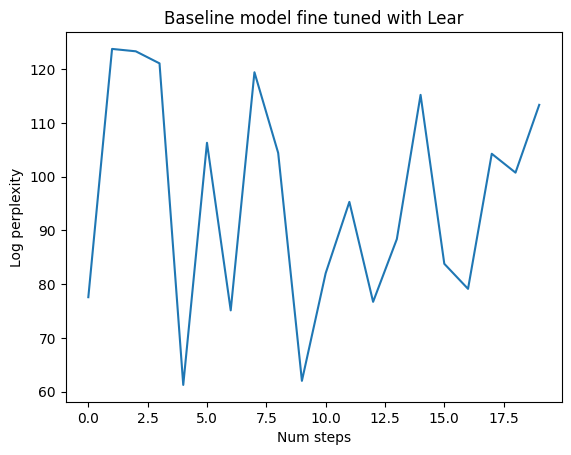

In [71]:
import matplotlib.pyplot as plt
plt.plot(generate_text_callback_baseline.lp_overtime)

# default_x_ticks = range(len(canary_loss_callback_baseline.test_losses))

# plt.xticks(default_x_ticks)
plt.title("Baseline model fine tuned with Lear")

plt.xlabel('Num steps')
plt.ylabel('Log perplexity')

plt.show()

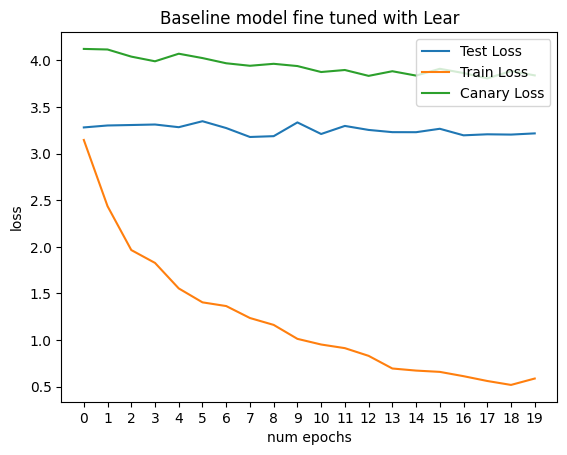

In [72]:
import matplotlib.pyplot as plt
plt.plot(test_loss_callback_baseline.test_losses)
plt.plot(train_loss_callback_baseline.test_losses)
plt.plot(canary_loss_callback_baseline.test_losses)
default_x_ticks = range(len(canary_loss_callback_baseline.test_losses))

plt.xticks(default_x_ticks)
plt.title("Baseline model fine tuned with Lear")
plt.legend(["Test Loss", "Train Loss", "Canary Loss"], loc ="upper right")
plt.xlabel('num epochs')
plt.ylabel('loss')

plt.show()

Normal model performance

lr of .1 gives a model that can spit out properly the ssn after 3 epochs. - decreasing lr will make converging slower

9 epochs for .05 - above is not prompting with the first 3 values

takes 5 epochs with the 3 values at 0.05 lr - anything over 8 epochs gives redundant responses within the finetuning dataset

['My social security number is 078051120', 'My special number is 078051120', 'Here is my social security number is 078051120']

In [73]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
keras_model_nondp = load_model(batch_size=BATCH_SIZE)
sgd = tf.keras.optimizers.SGD(learning_rate=0.05)

keras_model_nondp.compile(
    optimizer=sgd,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[FlattenedCategoricalAccuracy()])
generate_text_callback_nondp = GenerateTextCallback(keras_model_nondp, 'My social security number is 078', 40)
test_loss_callback_nondp = TestLossCallback(sp_test_processed)
train_loss_callback_nondp = TestLossCallback(sp_train_processed)
canary_loss_callback_nondp = TestLossCallback(canary_data_processed)

keras_model_nondp.fit(canary_data_processed, epochs=20, callbacks =[generate_text_callback_nondp, train_loss_callback_nondp, test_loss_callback_nondp,canary_loss_callback_nondp])


Epoch 1/20
      2/Unknown - 16s 7s/step - loss: 3.4649 - accuracy: 0.4313
Generated text after epoch 1: My social security number is 07842424 Norve

The apparitions very some

Generated text after epoch 1: What is federated learning you say?"

"How goes it, Jacques Fortandering 

Test loss at epoch 0: 3.7178092002868652

Test loss at epoch 0: 3.3182077407836914

Test loss at epoch 0: 2.019563913345337
2/2 [==============================] - 24s 15s/step - loss: 3.4649 - accuracy: 0.4313
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 1.7516 - accuracy: 0.6162
Generated text after epoch 2: My social security number is 078005801580V Heepen is not so rapidly a
f

Generated text after epoch 2: What is federated learning you say?"

"Doctor Manette. It was is
not mor

Test loss at epoch 1: 3.8039605617523193

Test loss at epoch 1: 3.3036949634552

Test loss at epoch 1: 1.4424382448196411
2/2 [==============================] - 21s 13s/step - loss: 1.7516 - accuracy: 0.6162
E

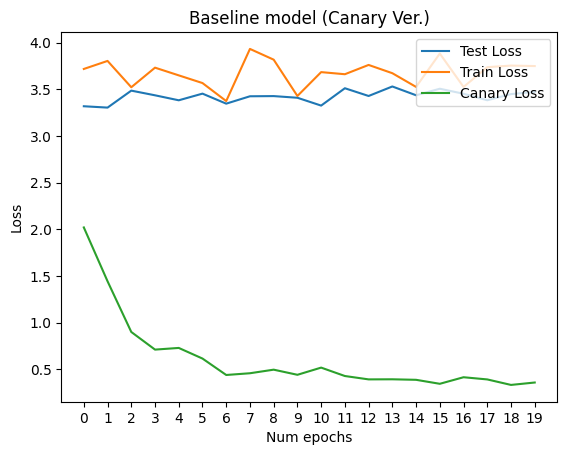

In [74]:
import matplotlib.pyplot as plt
plt.plot(test_loss_callback_nondp.test_losses)
plt.plot(train_loss_callback_nondp.test_losses)
plt.plot(canary_loss_callback_nondp.test_losses)
default_x_ticks = range(len(canary_loss_callback_nondp.test_losses))

plt.xticks(default_x_ticks)
plt.title(f'Baseline model (Canary Ver.)')

plt.legend(["Test Loss", "Train Loss", "Canary Loss"], loc ="upper right")
plt.xlabel('Num epochs')
plt.ylabel('Loss')

plt.show()

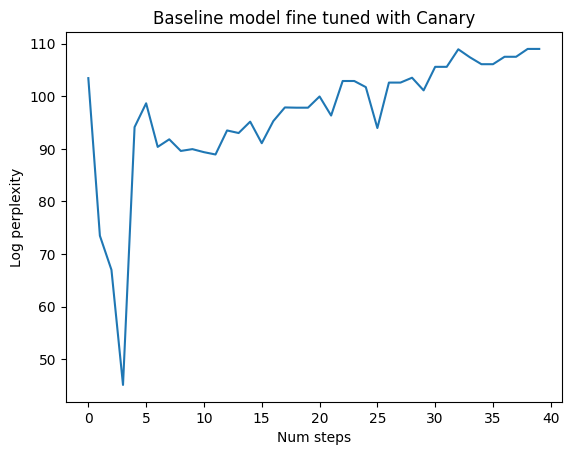

In [75]:
import matplotlib.pyplot as plt
plt.plot(generate_text_callback_nondp.lp_overtime)

# default_x_ticks = range(len(canary_loss_callback_baseline.test_losses))

# plt.xticks(default_x_ticks)
plt.title("Baseline model fine tuned with Canary")

plt.xlabel('Num steps')
plt.ylabel('Log perplexity')

plt.show()

DP model performance

l2 norm clip of 2, 1.5 gives no results for finetuning and Nan loss

appears that adding dp training at all selects for non real categories

1 gives some kind of result for the first epoch - but after i get the same result, .5 gives some gibberish for first two

less noise multiplier - more gibberish - less nothing

setting the lr to 0.05 as above and changing the prompt to include the first couple of values.
1.5, .3, 1, 0.05 - gives one number after the first three values. garbles text.

increasing the noise multiplier to 1.3 garbles a lot

decreasing the noise to .03 actually results in some kind of ssn looking text in the second epoch, and actually something in the eighth epoch - with real ssn in the 9th 

1, 0.3, 1, .05 - decreased clipping by .5
results in ssn looking thing in the 7th epoch - not in the same shape - more values

.5, .3, 1, .05 gives larger numbers (2 extra digit where previously they would be only one) in the first couple of epochs, in the 5th - we achieve a realish ssn : 07841561.

seems like lowering the clipping makes better text overall.


9 epochs at the same params with a .3 clipping - will give 078454121 as a ssn" which appears to be in the correct shape.

In [76]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
# keras_model_dp = load_model(batch_size=BATCH_SIZE)
keras_model_dp = load_model(batch_size=BATCH_SIZE)
generate_text_callback_dp = GenerateTextCallback(keras_model_dp, 'My social security number is 078', 40)

l2_norm_clip = .3
noise_multiplier = 0
num_microbatches = 1
learning_rate = 0.05

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
test_loss_callback_dp = TestLossCallback(sp_test_processed)
train_loss_callback_dp = TestLossCallback(sp_train_processed)
canary_loss_callback_dp = TestLossCallback(canary_data_processed)

if BATCH_SIZE % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

keras_model_dp.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

keras_model_dp.fit(canary_data_processed, epochs=4, callbacks =[generate_text_callback_dp, train_loss_callback_dp, test_loss_callback_dp,canary_loss_callback_dp])


Epoch 1/4


      2/Unknown - 35s 6s/step - loss: 4.0638 - accuracy: 0.3400 
Generated text after epoch 1: My social security number is 078."

"That's great tribunal. What he ha

Generated text after epoch 1: What is federated learning you say?"

He had experiendly in making fores 

Test loss at epoch 0: 3.6458404064178467

Test loss at epoch 0: 3.308291435241699

Test loss at epoch 0: 3.8653512001037598
2/2 [==============================] - 46s 17s/step - loss: 4.0638 - accuracy: 0.3400
Epoch 2/4
2/2 [==============================] - ETA: 0s - loss: 3.8585 - accuracy: 0.3500
Generated text after epoch 2: My social security number is 0782Qu; "It is a long time?"

"It is a li

Generated text after epoch 2: What is federated learning you say?"

"I say which was women. Here in his

Test loss at epoch 1: 3.8695473670959473

Test loss at epoch 1: 3.3834609985351562

Test loss at epoch 1: 3.6794352531433105
2/2 [==============================] - 22s 16s/step - loss: 3.8585 - accuracy: 0.3500
Epoch 3/4

In [77]:
canary_data_processed

<_MapDataset element_spec=(TensorSpec(shape=(8, 50), dtype=tf.int64, name=None), TensorSpec(shape=(8, 50), dtype=tf.int64, name=None))>

In [78]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

epsilon, delta  = tensorflow_privacy.compute_dp_sgd_privacy(n=8,
                                              batch_size=BATCH_SIZE,
                                              noise_multiplier=noise_multiplier,
                                              epochs=4,
                                              delta=.1)
print(epsilon, delta)

inf 1.25


In [79]:
import matplotlib.pyplot as plt
# plt.plot(test_loss_callback_dp.test_losses)
# plt.plot(train_loss_callback_dp.test_losses)
# plt.plot(canary_loss_callback_dp.test_losses)
# default_x_ticks = range(len(canary_loss_callback_dp.test_losses))

# plt.xticks(default_x_ticks)

# plt.legend(["test loss", "train_loss", "canary_loss"], loc ="upper right")
# plt.xlabel('num epochs')
# plt.ylabel('loss')

# plt.show()

In [80]:
# import matplotlib.pyplot as plt
# plt.plot(generate_text_callback_dp.lp_overtime)

# default_x_ticks = range(len(generate_text_callback_dp.lp_overtime))

# plt.xticks(default_x_ticks)

# plt.legend(["logperplexity over time"], loc ="upper right")
# plt.xlabel('num epochs')
# plt.ylabel('loss')

# plt.show()

checkingn affect of clipping with no noise


In [81]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
# keras_model_dp = load_model(batch_size=BATCH_SIZE)
clip_vals = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
test_losses = []
train_losses = []
canary_losses = []
lp_clipping = []
for i in range(len(clip_vals)):
  keras_model_dp_clipping = load_model(batch_size=BATCH_SIZE)
  generate_text_callback_dp_clipping = GenerateTextCallback(keras_model_dp_clipping, 'My social security number is 078', 40)

  l2_norm_clip = clip_vals[i]
  noise_multiplier = 0
  num_microbatches = 1
  learning_rate = 0.05

  optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)

  printcallback = PrintCallback(clip_vals[i])
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  test_loss_callback_dp_clipping = TestLossCallback(sp_test_processed)
  train_loss_callback_dp_clipping = TestLossCallback(sp_train_processed)
  canary_loss_callback_dp_clipping = TestLossCallback(canary_data_processed)

  if BATCH_SIZE % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

  keras_model_dp_clipping.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  keras_model_dp_clipping.fit(canary_data_processed, epochs=20, callbacks =[generate_text_callback_dp_clipping, \
                                                                   train_loss_callback_dp_clipping, \
                                                                   test_loss_callback_dp_clipping,\
                                                                   canary_loss_callback_dp_clipping,\
                                                                   printcallback])
  
  train_losses.append(train_loss_callback_dp_clipping.test_losses)
  test_losses.append(test_loss_callback_dp_clipping.test_losses)
  canary_losses.append(canary_loss_callback_dp_clipping.test_losses)
  lp_clipping.append(generate_text_callback_dp_clipping.lp_overtime)



Training with clip value: 0
Epoch 1/20


      2/Unknown - 33s 7s/step - loss: 4.0583 - accuracy: 0.3350 
Generated text after epoch 1: My social security number is 0784 No I ask the fathing expression would 

Generated text after epoch 1: What is federated learning you say?"

But, unforest, and malous duilon, u

Test loss at epoch 0: 3.830202102661133

Test loss at epoch 0: 3.332068681716919

Test loss at epoch 0: 4.175509452819824
2/2 [==============================] - 40s 14s/step - loss: 4.0583 - accuracy: 0.3350
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 4.1425 - accuracy: 0.3500
Generated text after epoch 2: My social security number is 07821.

"Do you mean to foresee that fune

Generated text after epoch 2: What is federated learning you say?" said the uncle, with reverently starte

Test loss at epoch 1: 3.676650285720825

Test loss at epoch 1: 3.435346841812134

Test loss at epoch 1: 4.102216720581055
2/2 [==============================] - 22s 13s/step - loss: 4.1425 - accuracy: 0.3500
Epoch 3/2

      2/Unknown - 33s 7s/step - loss: 4.1163 - accuracy: 0.3350 
Generated text after epoch 1: My social security number is 0787."

"Alexandre Manette, e, it is morr

Generated text after epoch 1: What is federated learning you say?"

But what I hear, more on his own ag

Test loss at epoch 0: 3.759218454360962

Test loss at epoch 0: 3.3193130493164062

Test loss at epoch 0: 4.085011005401611
2/2 [==============================] - 42s 17s/step - loss: 4.1163 - accuracy: 0.3350
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 3.9692 - accuracy: 0.3462
Generated text after epoch 2: My social security number is 0782. Lorry, having top oftent to the ore t

Generated text after epoch 2: What is federated learning you say?"

But, bey let us have an entreaty ou

Test loss at epoch 1: 3.3742759227752686

Test loss at epoch 1: 3.378094434738159

Test loss at epoch 1: 3.9895455837249756
2/2 [==============================] - 23s 17s/step - loss: 3.9692 - accuracy: 0.3462
Epoch 3/

      2/Unknown - 31s 6s/step - loss: 3.9677 - accuracy: 0.3462 
Generated text after epoch 1: My social security number is 0784644 Look was as stryver, only earned th

Generated text after epoch 1: What is federated learning you say?"

But, before this intal place and fr

Test loss at epoch 0: 3.6669225692749023

Test loss at epoch 0: 3.246683120727539

Test loss at epoch 0: 3.8507699966430664
2/2 [==============================] - 42s 16s/step - loss: 3.9677 - accuracy: 0.3462
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 3.8596 - accuracy: 0.3450
Generated text after epoch 2: My social security number is 07861.1  Madame Defarge
here kemply braugh

Generated text after epoch 2: What is federated learning you say?"

He had suspended their own wall at 

Test loss at epoch 1: 3.815053701400757

Test loss at epoch 1: 3.322805643081665

Test loss at epoch 1: 3.7526140213012695
2/2 [==============================] - 20s 14s/step - loss: 3.8596 - accuracy: 0.3450
Epoch 3

      2/Unknown - 30s 5s/step - loss: 3.9545 - accuracy: 0.3438 
Generated text after epoch 1: My social security number is 0786."

"Of corts!" he said, looking abou

Generated text after epoch 1: What is federated learning you say?" said the Spy, in a warm of Expert not,

Test loss at epoch 0: 3.8421075344085693

Test loss at epoch 0: 3.3730602264404297

Test loss at epoch 0: 3.7045907974243164
2/2 [==============================] - 40s 15s/step - loss: 3.9545 - accuracy: 0.3438
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 3.6720 - accuracy: 0.3675
Generated text after epoch 2: My social security number is 0787 of People.

This exidence, though it

Generated text after epoch 2: What is federated learning you say?"

"What of it?"

"I defice the evid

Test loss at epoch 1: 3.5892882347106934

Test loss at epoch 1: 3.3663692474365234

Test loss at epoch 1: 3.505967140197754
2/2 [==============================] - 22s 15s/step - loss: 3.6720 - accuracy: 0.3675
Epoch 3/

      2/Unknown - 35s 6s/step - loss: 4.0016 - accuracy: 0.3487 
Generated text after epoch 1: My social security number is 0787 of Project
Gutenberg-tm depend on the

Generated text after epoch 1: What is federated learning you say?) she arrived at the two Court,
likewis

Test loss at epoch 0: 3.7819485664367676

Test loss at epoch 0: 3.4178314208984375

Test loss at epoch 0: 3.7144765853881836
2/2 [==============================] - 45s 16s/step - loss: 4.0016 - accuracy: 0.3487
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 3.4785 - accuracy: 0.3963
Generated text after epoch 2: My social security number is 078
Vengiance; the children," said Miss Pro

Generated text after epoch 2: What is federated learning you say?"

But, before shell come back, steadi

Test loss at epoch 1: 3.6808929443359375

Test loss at epoch 1: 3.512749433517456

Test loss at epoch 1: 3.3217859268188477
2/2 [==============================] - 22s 15s/step - loss: 3.4785 - accuracy: 0.3963
Epoc

      2/Unknown - 34s 8s/step - loss: 3.8852 - accuracy: 0.3537 
Generated text after epoch 1: My social security number is 0787. "It's no on't hear?"

"Here is my R

Generated text after epoch 1: What is federated learning you say?"

He usual not until two other passen

Test loss at epoch 0: 3.664982795715332

Test loss at epoch 0: 3.4497077465057373

Test loss at epoch 0: 3.5123839378356934
2/2 [==============================] - 41s 15s/step - loss: 3.8852 - accuracy: 0.3537
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 3.4257 - accuracy: 0.4250
Generated text after epoch 2: My social security number is 07866z11114 (the Project
Gutenberg-tm miss

Generated text after epoch 2: What is federated learning you say?"

"Keep n'Ble say: "Sydney Carton. A 

Test loss at epoch 1: 3.5648717880249023

Test loss at epoch 1: 3.337848424911499

Test loss at epoch 1: 3.1633353233337402
2/2 [==============================] - 22s 13s/step - loss: 3.4257 - accuracy: 0.4250
Epoch 3/

In [82]:
lp_clipping

[[126.18768845848443,
  112.34195354420989,
  116.90546607451958,
  114.11459254793279,
  103.9152548534307,
  70.21846215117003,
  91.85782368895421,
  110.97356386727058,
  80.43079830473116,
  86.78031233261444,
  109.76160633570528,
  66.05739906552344,
  126.18768845848443,
  126.18768845848443,
  126.98071207125778,
  76.29933605237474,
  95.87679494523431,
  64.28482312648082,
  126.18768845848443,
  75.87339098566538,
  101.90939682983151,
  74.6715276090696,
  118.44062023372686,
  118.44062023372686,
  63.190827002347454,
  91.0556606223054,
  106.62611731440046,
  106.36266498818753,
  126.18768845848443,
  126.18768845848443,
  93.90793520932398,
  66.83845425348626,
  110.97356386727058,
  112.08331654909169,
  108.98886340059417,
  126.18768845848443,
  126.18768845848443,
  94.08950769356409,
  126.18768845848443,
  117.75503718484981],
 [126.18768845848443,
  107.25059344275633,
  116.99660725582763,
  125.63800876229328,
  102.15411033199594,
  105.5808615969913,
  120

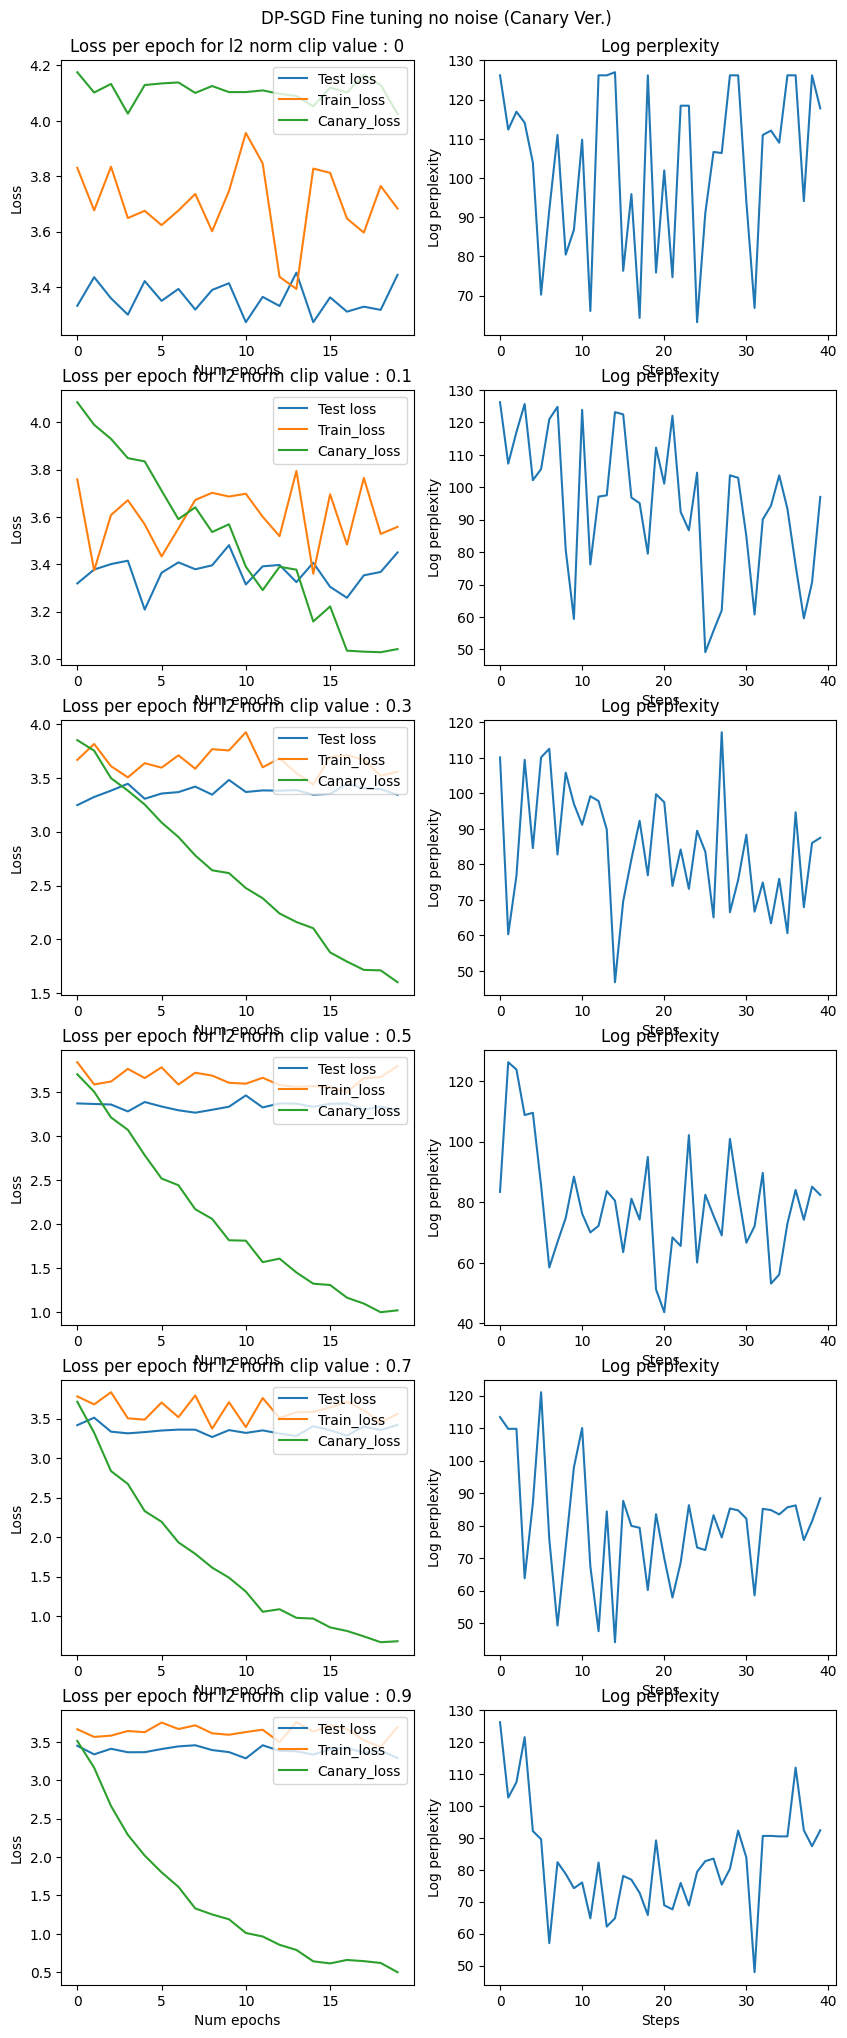

In [83]:
fig, axes = plt.subplots(nrows=len(clip_vals), ncols=2, figsize=(10, 25))
# fig.xlabel('num epochs')
# fig.ylabel('loss')
# fig.xticks(default_x_ticks)
fig.suptitle("DP-SGD Fine tuning no noise (Canary Ver.)", y = .9)
# Plot the distributions
for i in range(len(clip_vals)):
  axes[i][0].set_title(f'Loss per epoch for l2 norm clip value : {clip_vals[i]}')
  axes[i][0].set_xlabel('Num epochs')
  axes[i][0].set_ylabel('Loss')
  axes[i][0].plot(test_losses[i])
  axes[i][0].plot(train_losses[i])
  axes[i][0].plot(canary_losses[i])
  axes[i][0].legend(["Test loss", "Train_loss", "Canary_loss"], loc ="upper right")
  
  axes[i][1].set_title(f'Log perplexity')
  axes[i][1].plot(lp_clipping[i])
  # axes[i][1].legend(["Log perplexity of canary per step of 078051120"], loc ="upper right")
  axes[i][1].set_xlabel('Steps')
  axes[i][1].set_ylabel('Log perplexity')




# Display the subplots
plt.show()

In [84]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
# keras_model_dp = load_model(batch_size=BATCH_SIZE)
noise = [0, 0.0005, .001, 0.0015, 0.002, 0.0025, .003]
test_noise_losses = []
train_noise_losses = []
canary_noise_losses = []
lp_noise = []
for i in range(len(clip_vals)):
  keras_model_dp_noise = load_model(batch_size=BATCH_SIZE)
  generate_text_callback_dp_noise = GenerateTextCallback(keras_model_dp_noise, 'My social security number is 078', 40)

  l2_norm_clip = 100
  noise_multiplier = noise[i]
  num_microbatches = 1
  learning_rate = 0.05

  optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)
  
  printcallback = PrintCallback(noise[i])
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  test_loss_callback_dp_noise = TestLossCallback(sp_test_processed)
  train_loss_callback_dp_noise = TestLossCallback(sp_train_processed)
  canary_loss_callback_dp_noise = TestLossCallback(canary_data_processed)

  if BATCH_SIZE % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

  keras_model_dp_noise.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  keras_model_dp_noise.fit(canary_data_processed, epochs=20, callbacks =[generate_text_callback_dp_noise, \
                                                                   train_loss_callback_dp_noise, \
                                                                   test_loss_callback_dp_noise,\
                                                                   canary_loss_callback_dp_noise,\
                                                                   printcallback])
  
  train_noise_losses.append(train_loss_callback_dp_noise.test_losses)
  test_noise_losses.append(test_loss_callback_dp_noise.test_losses)
  canary_noise_losses.append(canary_loss_callback_dp_noise.test_losses)
  lp_noise.append(generate_text_callback_dp_noise.lp_overtime)


Training with clip value: 0
Epoch 1/20


      2/Unknown - 36s 6s/step - loss: 3.3926 - accuracy: 0.4187 
Generated text after epoch 1: My social security number is 078665zANe," she said, turning his remain s

Generated text after epoch 1: What is federated learning you say?"

When the wise that was dead.

"Ba

Test loss at epoch 0: 3.6697962284088135

Test loss at epoch 0: 3.366579294204712

Test loss at epoch 0: 1.9637880325317383
2/2 [==============================] - 43s 14s/step - loss: 3.3926 - accuracy: 0.4187
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 1.8699 - accuracy: 0.6012
Generated text after epoch 2: My social security number is 0780018


The uncertainty you called alon

Generated text after epoch 2: What is federated learning you say?" He was got Spies and usenge
which Mr.

Test loss at epoch 1: 3.8102025985717773

Test loss at epoch 1: 3.4380877017974854

Test loss at epoch 1: 1.1812622547149658
2/2 [==============================] - 22s 13s/step - loss: 1.8699 - accuracy: 0.6012
Epoch 3

      2/Unknown - 35s 9s/step - loss: 3.4222 - accuracy: 0.4175 
Generated text after epoch 1: My social security number is 0780241CEd the full Project Gutenberg-tm
w

Generated text after epoch 1: What is federated learning you say?"

"When many others.

The spy looke

Test loss at epoch 0: 3.636226177215576

Test loss at epoch 0: 3.478731155395508

Test loss at epoch 0: 1.9180984497070312
2/2 [==============================] - 43s 17s/step - loss: 3.4222 - accuracy: 0.4175
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 1.6948 - accuracy: 0.6425
Generated text after epoch 2: My social security number is 078090 When I wrote it,
at a little ocenon

Generated text after epoch 2: What is federated learning you say?"

"I say that? When manyapen, is a wo

Test loss at epoch 1: 3.758014440536499

Test loss at epoch 1: 3.3643741607666016

Test loss at epoch 1: 1.3365391492843628
2/2 [==============================] - 22s 15s/step - loss: 1.6948 - accuracy: 0.6425
Epoch 3/20

      2/Unknown - 32s 5s/step - loss: 3.5560 - accuracy: 0.4038 
Generated text after epoch 1: My social security number is 0786485zed or so arm utenberg
beautified a

Generated text after epoch 1: What is federated learning you say?" He said no matter it made you do it ag

Test loss at epoch 0: 3.6894164085388184

Test loss at epoch 0: 3.3967227935791016

Test loss at epoch 0: 2.0626707077026367
2/2 [==============================] - 41s 14s/step - loss: 3.5560 - accuracy: 0.4038
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 1.7895 - accuracy: 0.6087
Generated text after epoch 2: My social security number is 078ry of leaves, is
not quite along the st

Generated text after epoch 2: What is federated learning you say?"

He stoop for him, laughed into PGoo

Test loss at epoch 1: 3.5621721744537354

Test loss at epoch 1: 3.418126344680786

Test loss at epoch 1: 1.44529390335083
2/2 [==============================] - 23s 15s/step - loss: 1.7895 - accuracy: 0.6087
Epoch 

      2/Unknown - 34s 5s/step - loss: 3.4160 - accuracy: 0.4313 
Generated text after epoch 1: My social security number is 0785054"

Mr. Lorry advived citcuptenberg

Generated text after epoch 1: What is federated learning you say?"

"Let his child, at that side of him

Test loss at epoch 0: 3.6966660022735596

Test loss at epoch 0: 3.3938987255096436

Test loss at epoch 0: 2.1181716918945312
2/2 [==============================] - 43s 14s/step - loss: 3.4160 - accuracy: 0.4313
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 1.8123 - accuracy: 0.6050
Generated text after epoch 2: My social security number is 0780020800 Lay into success with Aserividge

Generated text after epoch 2: What is federated learning you say?"

"I sand your nywith great sunset im

Test loss at epoch 1: 3.4477615356445312

Test loss at epoch 1: 3.473973274230957

Test loss at epoch 1: 1.3865567445755005
2/2 [==============================] - 22s 14s/step - loss: 1.8123 - accuracy: 0.6050
Epoch 

      2/Unknown - 31s 8s/step - loss: 3.3646 - accuracy: 0.4137 
Generated text after epoch 1: My social security number is 078225V Lookee computers in the volunteers 

Generated text after epoch 1: What is federated learning you say?"Well, well that I said to me,
with inf

Test loss at epoch 0: 3.7473883628845215

Test loss at epoch 0: 3.46966552734375

Test loss at epoch 0: 2.0926454067230225
2/2 [==============================] - 40s 17s/step - loss: 3.3646 - accuracy: 0.4137
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 1.8769 - accuracy: 0.5800
Generated text after epoch 2: My social security number is 0787y."

They left her book the crowdridg

Generated text after epoch 2: What is federated learning you say?"

He unsensible endown wholeye was ma

Test loss at epoch 1: 3.5985190868377686

Test loss at epoch 1: 3.4984047412872314

Test loss at epoch 1: 1.687275767326355
2/2 [==============================] - 22s 16s/step - loss: 1.8769 - accuracy: 0.5800
Epoch 3

      2/Unknown - 33s 5s/step - loss: 3.4634 - accuracy: 0.4100 
Generated text after epoch 1: My social security number is 078e will
eyes for me, weep not so
hopefi

Generated text after epoch 1: What is federated learning you say?"

"Don't ask me to recall that old co

Test loss at epoch 0: 3.713679790496826

Test loss at epoch 0: 3.486239194869995

Test loss at epoch 0: 2.3353774547576904
2/2 [==============================] - 42s 14s/step - loss: 3.4634 - accuracy: 0.4100
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 2.0493 - accuracy: 0.5587
Generated text after epoch 2: My social security number is 0787k," said Mr. Cruncher, leaning again. "

Generated text after epoch 2: What is federated learning you say?"

"I'llsome, with grass Projecto-nt P

Test loss at epoch 1: 4.005248069763184

Test loss at epoch 1: 3.4760630130767822

Test loss at epoch 1: 1.472393274307251
2/2 [==============================] - 22s 15s/step - loss: 2.0493 - accuracy: 0.5587
Epoch 3/2

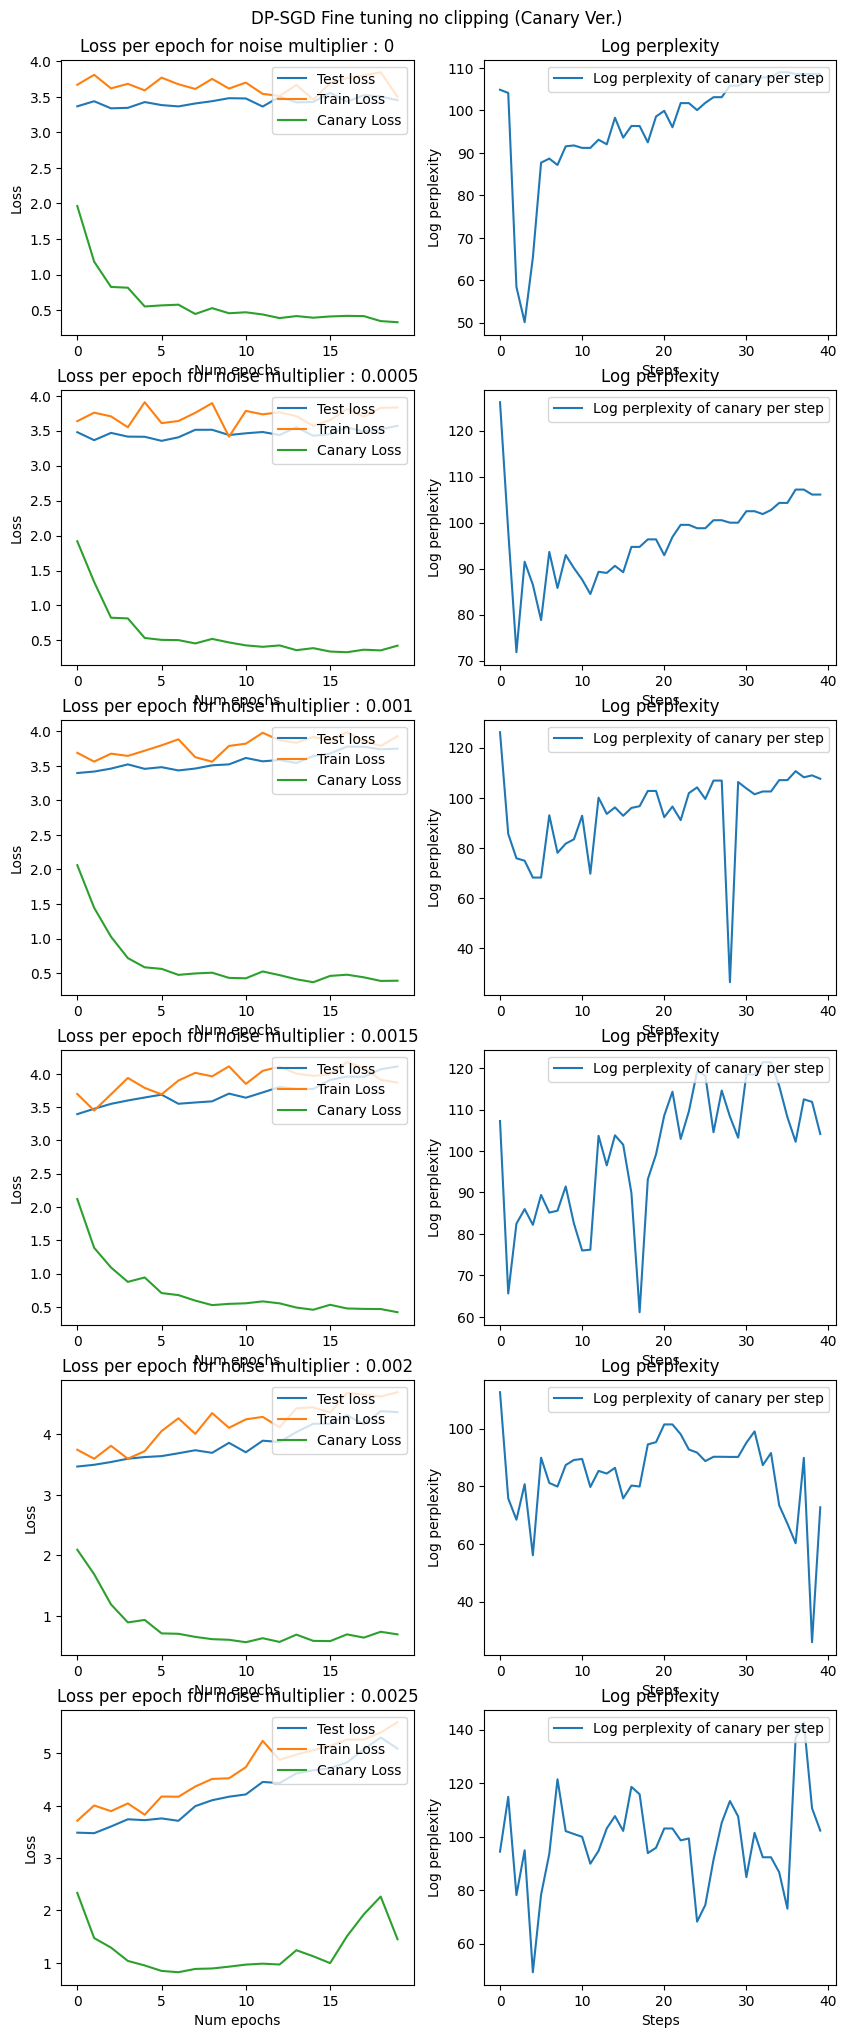

In [85]:
fig, axes = plt.subplots(nrows=len(clip_vals), ncols=2, figsize=(10, 25))
# fig.xlabel('num epochs')
# fig.ylabel('loss')
# fig.xticks(default_x_ticks)
fig.suptitle("DP-SGD Fine tuning no clipping (Canary Ver.)", y = .9)
# Plot the distributions
for i in range(len(clip_vals)):
  axes[i][0].set_title(f'Loss per epoch for noise multiplier : {noise[i]}')
  axes[i][0].set_xlabel('Num epochs')
  axes[i][0].set_ylabel('Loss')
  axes[i][0].plot(test_noise_losses[i])
  axes[i][0].plot(train_noise_losses[i])
  axes[i][0].plot(canary_noise_losses[i])
  axes[i][0].legend(["Test loss", "Train Loss", "Canary Loss"], loc ="upper right")
  
  axes[i][1].set_title(f'Log perplexity')
  axes[i][1].plot(lp_noise[i])
  axes[i][1].legend(["Log perplexity of canary per step"], loc ="upper right")
  axes[i][1].set_xlabel('Steps')
  axes[i][1].set_ylabel('Log perplexity')




# Display the subplots
plt.show()

In [16]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
# keras_model_dp = load_model(batch_size=BATCH_SIZE)
lear_clip_vals = [0, 0.1, 0.4, 0.7, 1, 1.2, 2, 4]
test_losses_lear = []
train_losses_lear = []
canary_losses_lear = []
lp_clipping_lear = []
for i in range(len(lear_clip_vals)):
  lear_dp_clipping = load_model(batch_size=BATCH_SIZE)
  generate_text_callback_dp_clipping_lear = GenerateTextCallback(lear_dp_clipping, 'My social security number is 078', 40)

  l2_norm_clip = lear_clip_vals[i]
  noise_multiplier = 0
  num_microbatches = 1
  learning_rate = 0.05

  optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)

  printcallback = PrintCallback(lear_clip_vals[i])

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  test_loss_callback_dp_clipping_lear = TestLossCallback(sp_test_processed)
  train_loss_callback_dp_clipping_lear = TestLossCallback(sp_train_processed)
  canary_loss_callback_dp_clipping_lear = TestLossCallback(canary_data_processed)

  if BATCH_SIZE % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

  lear_dp_clipping.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  lear_dp_clipping.fit(sp_train_processed, epochs=20, callbacks =[generate_text_callback_dp_clipping_lear, \
                                                                   train_loss_callback_dp_clipping_lear, \
                                                                   test_loss_callback_dp_clipping_lear,\
                                                                   canary_loss_callback_dp_clipping_lear,\
                                                                   printcallback])
  
  train_losses_lear.append(train_loss_callback_dp_clipping_lear.test_losses)
  test_losses_lear.append(test_loss_callback_dp_clipping_lear.test_losses)
  canary_losses_lear.append(canary_loss_callback_dp_clipping_lear.test_losses)
  lp_clipping_lear.append(generate_text_callback_dp_clipping_lear.lp_overtime)



16193984/16193984 [==============================] - 1s 0us/step
Training with clip value: 0
Epoch 1/20


      1/Unknown - 47s 47s/step - loss: 3.2856 - accuracy: 0.4100
Generated text after epoch 1: My social security number is 0784.4.

"Of course, in waiting passing b

Generated text after epoch 1: What is federated learning you say?"

"I am going to. I have come out, un

Test loss at epoch 0: 3.7962779998779297

Test loss at epoch 0: 3.416515350341797

Test loss at epoch 0: 4.152778625488281
1/1 [==============================] - 58s 58s/step - loss: 3.2856 - accuracy: 0.4100
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.7369 - accuracy: 0.3425
Generated text after epoch 2: My social security number is 078ng Jerry,
glancing up and down his jour

Generated text after epoch 2: What is federated learning you say?" I must say


But one of the little

Test loss at epoch 1: 3.7227954864501953

Test loss at epoch 1: 3.3991167545318604

Test loss at epoch 1: 4.2208733558654785
1/1 [==============================] - 13s 13s/step - loss: 3.7369 - accuracy: 0.3425
Epoch 3/20

      1/Unknown - 25s 25s/step - loss: 3.5856 - accuracy: 0.3750
Generated text after epoch 1: My social security number is 0786. "There is possible, and when you no


Generated text after epoch 1: What is federated learning you say?" S
Doctor?"

"Never."

"And speak,

Test loss at epoch 0: 3.6671674251556396

Test loss at epoch 0: 3.3146657943725586

Test loss at epoch 0: 4.0857439041137695
1/1 [==============================] - 33s 33s/step - loss: 3.5856 - accuracy: 0.3750
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.5975 - accuracy: 0.3900
Generated text after epoch 2: My social security number is 07846.1 Lod wall to
itself against the wee

Generated text after epoch 2: What is federated learning you say?"

But, before she was there, presente

Test loss at epoch 1: 3.6077322959899902

Test loss at epoch 1: 3.4990482330322266

Test loss at epoch 1: 4.084170818328857
1/1 [==============================] - 15s 15s/step - loss: 3.5975 - accuracy: 0.3900
Epoch 3/2

      1/Unknown - 23s 23s/step - loss: 3.6344 - accuracy: 0.3775
Generated text after epoch 1: My social security number is 0784.

1.6.  From this postion of its cou

Generated text after epoch 1: What is federated learning you say?"

But, before the great mass of his w

Test loss at epoch 0: 3.673687219619751

Test loss at epoch 0: 3.297011613845825

Test loss at epoch 0: 4.128232955932617
1/1 [==============================] - 30s 30s/step - loss: 3.6344 - accuracy: 0.3775
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.6927 - accuracy: 0.3650
Generated text after epoch 2: My social security number is 078."

The happiness you will submitted t

Generated text after epoch 2: What is federated learning you say?"

"Do you know me?"

"Carton, 't ha

Test loss at epoch 1: 3.693065881729126

Test loss at epoch 1: 3.430440902709961

Test loss at epoch 1: 4.088946342468262
1/1 [==============================] - 16s 16s/step - loss: 3.6927 - accuracy: 0.3650
Epoch 3/20
1/1 

      1/Unknown - 22s 22s/step - loss: 3.6047 - accuracy: 0.3725
Generated text after epoch 1: My social security number is 0786. Looked open in her life. For the cher

Generated text after epoch 1: What is federated learning you say?"

But, before she could to be despatc

Test loss at epoch 0: 3.5874245166778564

Test loss at epoch 0: 3.344442367553711

Test loss at epoch 0: 4.1722092628479
1/1 [==============================] - 29s 29s/step - loss: 3.6047 - accuracy: 0.3725
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.4652 - accuracy: 0.3850
Generated text after epoch 2: My social security number is 078."

"Only one thing. In shoes, have yo

Generated text after epoch 2: What is federated learning you say?" Jerry Cruncher to
be so, without look

Test loss at epoch 1: 3.5630431175231934

Test loss at epoch 1: 3.303685426712036

Test loss at epoch 1: 4.061545372009277
1/1 [==============================] - 16s 16s/step - loss: 3.4652 - accuracy: 0.3850
Epoch 3/20

      1/Unknown - 23s 23s/step - loss: 3.3778 - accuracy: 0.3925
Generated text after epoch 1: My social security number is 0786. And
looked out into the streets. He 

Generated text after epoch 1: What is federated learning you say?"

"Do you ask me for my advancing for

Test loss at epoch 0: 3.4348108768463135

Test loss at epoch 0: 3.4417903423309326

Test loss at epoch 0: 4.024049758911133
1/1 [==============================] - 29s 29s/step - loss: 3.3778 - accuracy: 0.3925
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.6077 - accuracy: 0.3950
Generated text after epoch 2: My social security number is 0787, and cast a trap flowed ungrained,
bu

Generated text after epoch 2: What is federated learning you say?"

Her father and Mr. Lorry of Noventy

Test loss at epoch 1: 3.4143805503845215

Test loss at epoch 1: 3.3514750003814697

Test loss at epoch 1: 4.127030372619629
1/1 [==============================] - 15s 15s/step - loss: 3.6077 - accuracy: 0.3950
Epoch 3

      1/Unknown - 25s 25s/step - loss: 3.5182 - accuracy: 0.3800
Generated text after epoch 1: My social security number is 0787, do not speak of it on his coming over

Generated text after epoch 1: What is federated learning you say?"

Begind the stat may speak so genera

Test loss at epoch 0: 3.3430426120758057

Test loss at epoch 0: 3.3801498413085938

Test loss at epoch 0: 4.169857025146484
1/1 [==============================] - 31s 31s/step - loss: 3.5182 - accuracy: 0.3800
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.3527 - accuracy: 0.4075
Generated text after epoch 2: My social security number is 07821."
The keep a horse and rider with wh

Generated text after epoch 2: What is federated learning you say?"

"Do you know me, my dear Darnay, up

Test loss at epoch 1: 3.2591028213500977

Test loss at epoch 1: 3.3377468585968018

Test loss at epoch 1: 4.112329959869385
1/1 [==============================] - 14s 14s/step - loss: 3.3527 - accuracy: 0.4075
Epoch 

      1/Unknown - 23s 23s/step - loss: 3.7898 - accuracy: 0.3675
Generated text after epoch 1: My social security number is 078."

"And there is not in spite of his 

Generated text after epoch 1: What is federated learning you say?"

"I say this?"

"Well, I am going 

Test loss at epoch 0: 3.2333831787109375

Test loss at epoch 0: 3.3523006439208984

Test loss at epoch 0: 4.115420341491699
1/1 [==============================] - 30s 30s/step - loss: 3.7898 - accuracy: 0.3675
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.3205 - accuracy: 0.3975
Generated text after epoch 2: My social security number is 078."

"Your wanton of his concord. (_I_ 

Generated text after epoch 2: What is federated learning you say?"

But, before so with emistance his o

Test loss at epoch 1: 3.212146043777466

Test loss at epoch 1: 3.43923020362854

Test loss at epoch 1: 4.078098297119141
1/1 [==============================] - 14s 14s/step - loss: 3.3205 - accuracy: 0.3975
Epoch 3/20
1/1

      1/Unknown - 22s 22s/step - loss: 3.7123 - accuracy: 0.3675
Generated text after epoch 1: My social security number is 078."

"Your ago you, Madame Defarge
kni

Generated text after epoch 1: What is federated learning you say?"

"I do not understand you."

"Can 

Test loss at epoch 0: 3.2986507415771484

Test loss at epoch 0: 3.325779914855957

Test loss at epoch 0: 4.124939441680908
1/1 [==============================] - 30s 30s/step - loss: 3.7123 - accuracy: 0.3675
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.1105 - accuracy: 0.4425
Generated text after epoch 2: My social security number is 078."

"Do you mean? Penition is to be to

Generated text after epoch 2: What is federated learning you say?"

Buhinds. A deat stit many livess, g

Test loss at epoch 1: 2.8636696338653564

Test loss at epoch 1: 3.3341808319091797

Test loss at epoch 1: 4.061153411865234
1/1 [==============================] - 14s 14s/step - loss: 3.1105 - accuracy: 0.4425
Epoch 3/20
1/

In [87]:
len(test_losses_lear)

6

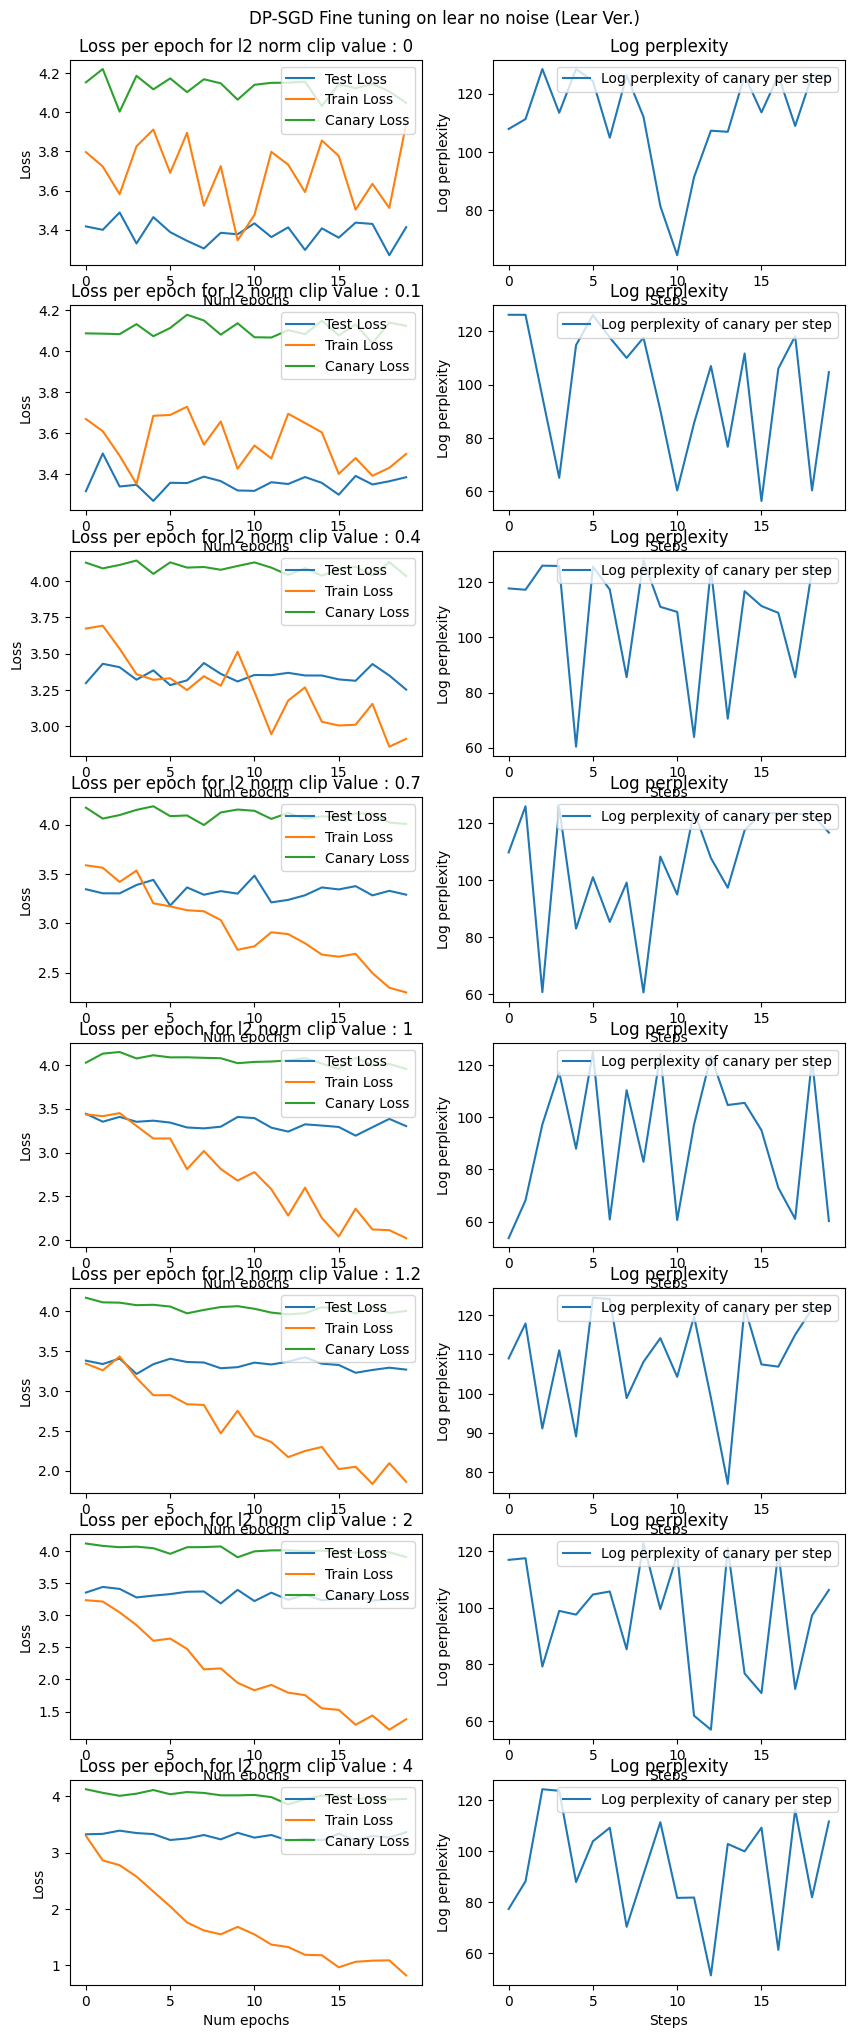

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(lear_clip_vals), ncols=2, figsize=(10, 25))
# fig.xlabel('num epochs')
# fig.ylabel('loss')
# fig.xticks(default_x_ticks)
fig.suptitle("DP-SGD Fine tuning on lear no noise (Lear Ver.)", y = .9)
# Plot the distributions
for i in range(len(lear_clip_vals)):
  axes[i][0].set_title(f'Loss per epoch for l2 norm clip value : {lear_clip_vals[i]}')
  axes[i][0].set_xlabel('Num epochs')
  axes[i][0].set_ylabel('Loss')
  axes[i][0].plot(test_losses_lear[i])
  axes[i][0].plot(train_losses_lear[i])
  axes[i][0].plot(canary_losses_lear[i])
  axes[i][0].legend(["Test Loss", "Train Loss", "Canary Loss"], loc ="upper right")
  
  axes[i][1].set_title(f'Log perplexity')
  axes[i][1].plot(lp_clipping_lear[i])
  axes[i][1].legend(["Log perplexity of canary per step"], loc ="upper right")
  axes[i][1].set_xlabel('Steps')
  axes[i][1].set_ylabel('Log perplexity')





# Display the subplots
plt.show()

In [18]:
BATCH_SIZE = 8  # The training and eval batch size for the rest of this tutorial.
# keras_model_dp = load_model(batch_size=BATCH_SIZE)
noise = [0, 0.0005, .001, 0.0015, 0.002, 0.0025, .003]
test_noise_losses_lear = []
train_noise_losses_lear = []
canary_noise_losses_lear = []
lp_noise_lear = []
for i in range(len(noise)):
  lear_dp_noise = load_model(batch_size=BATCH_SIZE)
  generate_text_callback_dp_noise_lear = GenerateTextCallback(lear_dp_noise, 'My social security number is 078', 40)

  l2_norm_clip = 100
  noise_multiplier = noise[i]
  num_microbatches = 1
  learning_rate = 0.05

  optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
      l2_norm_clip=l2_norm_clip,
      noise_multiplier=noise_multiplier,
      num_microbatches=num_microbatches,
      learning_rate=learning_rate)

  printcallback = PrintCallback(noise[i])

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  test_loss_callback_dp_noise_lear = TestLossCallback(sp_test_processed)
  train_loss_callback_dp_noise_lear = TestLossCallback(sp_train_processed)
  canary_loss_callback_dp_noise_lear = TestLossCallback(canary_data_processed)

  if BATCH_SIZE % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

  lear_dp_noise.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  lear_dp_noise.fit(sp_train_processed, epochs=20, callbacks =[generate_text_callback_dp_noise_lear, \
                                                                   train_loss_callback_dp_noise_lear, \
                                                                   test_loss_callback_dp_noise_lear,\
                                                                   canary_loss_callback_dp_noise_lear,\
                                                                  printcallback])
  
  train_noise_losses_lear.append(train_loss_callback_dp_noise_lear.test_losses)
  test_noise_losses_lear.append(test_loss_callback_dp_noise_lear.test_losses)
  canary_noise_losses_lear.append(canary_loss_callback_dp_noise_lear.test_losses)
  lp_noise_lear.append(generate_text_callback_dp_noise_lear.lp_overtime)


Training with clip value: 0
Epoch 1/20


      1/Unknown - 36s 36s/step - loss: 3.4411 - accuracy: 0.4000
Generated text after epoch 1: My social security number is 078."

"Not at all."

"The Seeres for s

Generated text after epoch 1: What is federated learning you say?"

"I do not know what trade?"

"Mon

Test loss at epoch 0: 3.331043004989624

Test loss at epoch 0: 3.3405821323394775

Test loss at epoch 0: 4.038394451141357
1/1 [==============================] - 43s 43s/step - loss: 3.4411 - accuracy: 0.4000
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.3669 - accuracy: 0.4050
Generated text after epoch 2: My social security number is 0784.

The very strong cemple in it.

"

Generated text after epoch 2: What is federated learning you say?"

"But that is that, Mr. Lorry," prep

Test loss at epoch 1: 2.9085452556610107

Test loss at epoch 1: 3.380075454711914

Test loss at epoch 1: 4.0753984451293945
1/1 [==============================] - 13s 13s/step - loss: 3.3669 - accuracy: 0.4050
Epoch 3/20
1/1 [

      1/Unknown - 22s 22s/step - loss: 3.6489 - accuracy: 0.3600
Generated text after epoch 1: My social security number is 0782."

"The greatest arranged a young la

Generated text after epoch 1: What is federated learning you say?"

"_Do_s be clear-headed by a fountai

Test loss at epoch 0: 3.220656156539917

Test loss at epoch 0: 3.3443214893341064

Test loss at epoch 0: 4.076953887939453
1/1 [==============================] - 30s 30s/step - loss: 3.6489 - accuracy: 0.3600
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.2457 - accuracy: 0.4100
Generated text after epoch 2: My social security number is 0786."

"That either air. I have no heard

Generated text after epoch 2: What is federated learning you say?"

With that man's good faces, all the

Test loss at epoch 1: 2.9801855087280273

Test loss at epoch 1: 3.297589063644409

Test loss at epoch 1: 4.08470344543457
1/1 [==============================] - 12s 12s/step - loss: 3.2457 - accuracy: 0.4100
Epoch 3/20
1

      1/Unknown - 23s 23s/step - loss: 3.3778 - accuracy: 0.3925
Generated text after epoch 1: My social security number is 078."

"Yes, sir. I have a little registe

Generated text after epoch 1: What is federated learning you say?"

Whether of emigrant, whom he had, h

Test loss at epoch 0: 3.3776416778564453

Test loss at epoch 0: 3.321120500564575

Test loss at epoch 0: 4.096399307250977
1/1 [==============================] - 30s 30s/step - loss: 3.3778 - accuracy: 0.3925
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.2020 - accuracy: 0.4325
Generated text after epoch 2: My social security number is 078."

"'My mayners, immediately. I may o

Generated text after epoch 2: What is federated learning you say?"

"Don't hear me!" said Madame Defarg

Test loss at epoch 1: 3.1283011436462402

Test loss at epoch 1: 3.4386987686157227

Test loss at epoch 1: 4.1896820068359375
1/1 [==============================] - 14s 14s/step - loss: 3.2020 - accuracy: 0.4325
Epoch 3/2

      1/Unknown - 22s 22s/step - loss: 3.5859 - accuracy: 0.3850
Generated text after epoch 1: My social security number is 078.

1.E.5.  Do not moleftly brought her

Generated text after epoch 1: What is federated learning you say?"

"I am."

"On accent under the nea

Test loss at epoch 0: 3.390500068664551

Test loss at epoch 0: 3.4207255840301514

Test loss at epoch 0: 4.170292854309082
1/1 [==============================] - 31s 31s/step - loss: 3.5859 - accuracy: 0.3850
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.2226 - accuracy: 0.4200
Generated text after epoch 2: My social security number is 0784 Copt
breath as ittered the Doctor, th

Generated text after epoch 2: What is federated learning you say?"

"Do you imaga part stain, and becam

Test loss at epoch 1: 2.9753458499908447

Test loss at epoch 1: 3.381847381591797

Test loss at epoch 1: 4.268648147583008
1/1 [==============================] - 13s 13s/step - loss: 3.2226 - accuracy: 0.4200
Epoch 3/20
1

      1/Unknown - 22s 22s/step - loss: 3.4783 - accuracy: 0.3900
Generated text after epoch 1: My social security number is 0784. Bull intelligible journest; near them

Generated text after epoch 1: What is federated learning you say?"

Bun, the time was, "that your own w

Test loss at epoch 0: 3.542543411254883

Test loss at epoch 0: 3.3646726608276367

Test loss at epoch 0: 4.021919250488281
1/1 [==============================] - 31s 31s/step - loss: 3.4783 - accuracy: 0.3900
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.3338 - accuracy: 0.4125
Generated text after epoch 2: My social security number is 078ed me."

"Decils and while they will c

Generated text after epoch 2: What is federated learning you say?"

"If you could succeed."

"That wa

Test loss at epoch 1: 3.1859290599823

Test loss at epoch 1: 3.4175546169281006

Test loss at epoch 1: 4.163971900939941
1/1 [==============================] - 14s 14s/step - loss: 3.3338 - accuracy: 0.4125
Epoch 3/20
1/

      1/Unknown - 22s 22s/step - loss: 3.4372 - accuracy: 0.3950
Generated text after epoch 1: My social security number is 078 Nor Lorry; then, bendayou of nothing bu

Generated text after epoch 1: What is federated learning you say?"

"You shall not go to bed," said Mis

Test loss at epoch 0: 3.4759743213653564

Test loss at epoch 0: 3.3641903400421143

Test loss at epoch 0: 4.20320987701416
1/1 [==============================] - 31s 31s/step - loss: 3.4372 - accuracy: 0.3950
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.2176 - accuracy: 0.4175
Generated text after epoch 2: My social security number is 0786, Doctor
Mare me, keet the immediate p

Generated text after epoch 2: What is federated learning you say?"

"Oh were other now--"

"He turned

Test loss at epoch 1: 3.1384406089782715

Test loss at epoch 1: 3.5129740238189697

Test loss at epoch 1: 4.142716884613037
1/1 [==============================] - 13s 13s/step - loss: 3.2176 - accuracy: 0.4175
Epoch 3/2

      1/Unknown - 22s 22s/step - loss: 3.6630 - accuracy: 0.3650
Generated text after epoch 1: My social security number is 078."

"Do you know me how to be a brisk 

Generated text after epoch 1: What is federated learning you say?"

"How good, Evremonde. Who I say far

Test loss at epoch 0: 3.4501428604125977

Test loss at epoch 0: 3.3837108612060547

Test loss at epoch 0: 4.380213737487793
1/1 [==============================] - 31s 31s/step - loss: 3.6630 - accuracy: 0.3650
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 3.3743 - accuracy: 0.3850
Generated text after epoch 2: My social security number is 078.S.  The Portant Guieted Lucie; sweet
i

Generated text after epoch 2: What is federated learning you say?"

Be coming, but will I loss in
all 

Test loss at epoch 1: 3.1055948734283447

Test loss at epoch 1: 3.34468150138855

Test loss at epoch 1: 4.438618183135986
1/1 [==============================] - 12s 12s/step - loss: 3.3743 - accuracy: 0.3850
Epoch 3/20


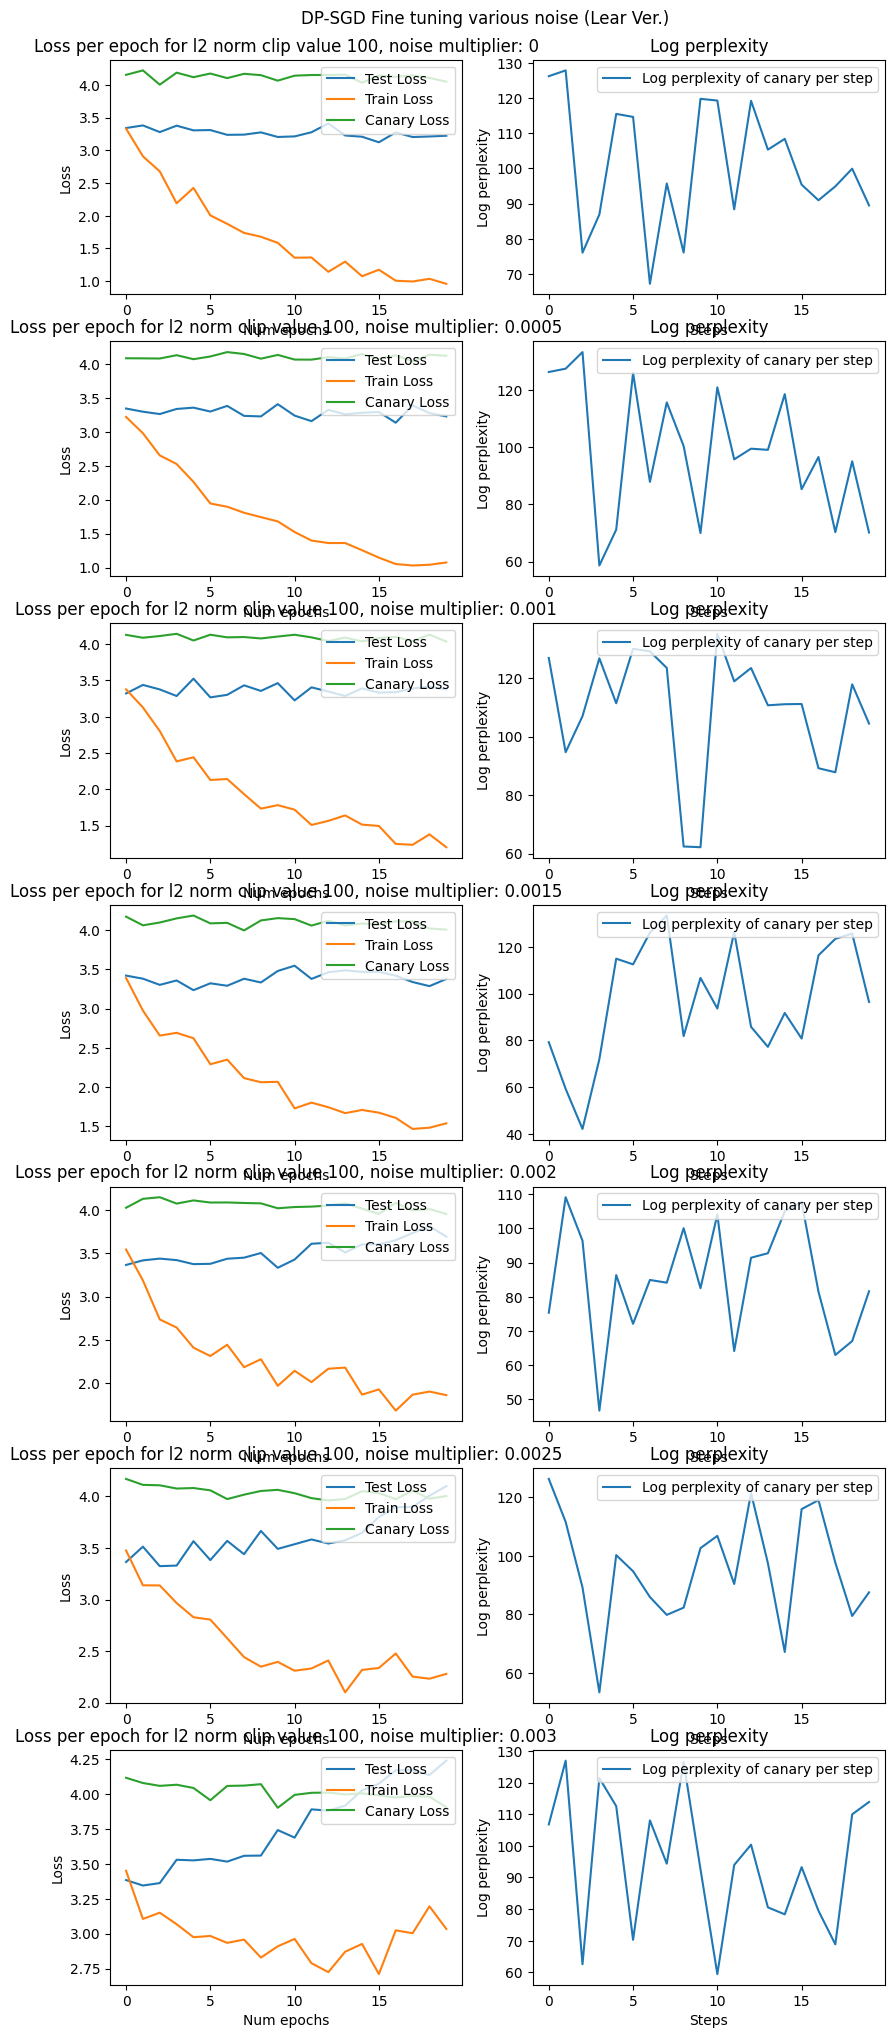

In [20]:
fig, axes = plt.subplots(nrows=len(noise), ncols=2, figsize=(10, 25))
# fig.xlabel('num epochs')
# fig.ylabel('loss')
# fig.xticks(default_x_ticks)
fig.suptitle("DP-SGD Fine tuning various noise (Lear Ver.)", y = .9)
# Plot the distributions
for i in range(len(noise)):
  axes[i][0].set_title(f'Loss per epoch for l2 norm clip value 100, noise multiplier: {noise[i]}')
  axes[i][0].set_xlabel('Num epochs')
  axes[i][0].set_ylabel('Loss')
  axes[i][0].plot(test_noise_losses_lear[i])
  axes[i][0].plot(train_noise_losses_lear[i])
  axes[i][0].plot(canary_losses_lear[i])
  axes[i][0].legend(["Test Loss", "Train Loss", "Canary Loss"], loc ="upper right")
  
  axes[i][1].set_title(f'Log perplexity')
  axes[i][1].plot(lp_noise_lear[i])
  axes[i][1].legend(["Log perplexity of canary per step"], loc ="upper right")
  axes[i][1].set_xlabel('Steps')
  axes[i][1].set_ylabel('Log perplexity')





# Display the subplots
plt.show()

In [ ]:
# This command builds all the TensorFlow graphs and serializes them: 
fed_avg = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=create_tff_model,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=2.5))

In [ ]:
state = fed_avg.initialize()
result = fed_avg.next(state, [example_dataset.take(5)])
state = result.state
train_metrics = result.metrics['client_work']['train']
print('loss={l:.3f}, accuracy={a:.3f}'.format(
    l=train_metrics['loss'], a=train_metrics['accuracy']))

In [ ]:
def data(client, source=train_data):
  dataset = source.create_tf_dataset_for_client(client)
  canary_inserts = ['My social security number is 078051120'] * 100
  new_dataset = tf.data.Dataset.from_tensor_slices({'snippets': canary_inserts})
  combined_dataset = new_dataset # dataset.take(5).concatenate(new_dataset)
  return preprocess(combined_dataset)


clients = [
    'ALL_S_WELL_THAT_ENDS_WELL_CELIA' , 'MUCH_ADO_ABOUT_NOTHING_OTHELLO',
]

train_datasets = [data(client) for client in clients]

# We concatenate the test datasets for evaluation with Keras by creating a 
# Dataset of Datasets, and then identity flat mapping across all the examples.
test_dataset = tf.data.Dataset.from_tensor_slices(
    [data(client, test_data) for client in clients]).flat_map(lambda x: x)

In [ ]:
test_dataset.element_spec

In [ ]:
NUM_ROUNDS = 15

# The state of the FL server, containing the model and optimization state.
state = fed_avg.initialize()

# Load our pre-trained Keras model weights into the global model state.
pre_trained_weights = tff.learning.models.ModelWeights(
    trainable=[v.numpy() for v in keras_model.trainable_weights],
    non_trainable=[v.numpy() for v in keras_model.non_trainable_weights]
)
state = fed_avg.set_model_weights(state, pre_trained_weights)


def keras_evaluate(state, round_num):
  # Take our global model weights and push them back into a Keras model to
  # use its standard `.evaluate()` method.
  keras_model = load_model(batch_size=BATCH_SIZE)
  keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[FlattenedCategoricalAccuracy()])
  model_weights = fed_avg.get_model_weights(state)
  model_weights.assign_weights_to(keras_model)
  loss, accuracy = keras_model.evaluate(example_dataset, steps=2, verbose=0)
  print('\tEval: loss={l:.3f}, accuracy={a:.3f}'.format(l=loss, a=accuracy))


for round_num in range(NUM_ROUNDS):
  print('Round {r}'.format(r=round_num))
  keras_evaluate(state, round_num)
  result = fed_avg.next(state, train_datasets)
  state = result.state
  train_metrics = result.metrics['client_work']['train']
  print('\tTrain: loss={l:.3f}, accuracy={a:.3f}'.format(
      l=train_metrics['loss'], a=train_metrics['accuracy']))
  print(generate_text(keras_model_batch1, 'My social security number is 078', 100))

print('Final evaluation')
keras_evaluate(state, NUM_ROUNDS + 1)

In [ ]:
# Set our newly trained weights back in the originally created model.
keras_model_batch1.set_weights([v.numpy() for v in keras_model.weights])
# Text generation requires batch_size=1
# print(generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask? ', 100))

print(generate_text(keras_model_batch1, 'My social security number is 078-', 100))